In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/movies_overview.csv')
df.head()

,title,overview,genre_ids
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]"
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[18, 80]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18]


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      9980 non-null   object
 1   overview   9980 non-null   object
 2   genre_ids  9980 non-null   object
dtypes: object(3)
memory usage: 234.0+ KB


In [4]:
df["genre_ids"].value_counts()

genre_ids
[18]                           577
[35]                           571
[18, 10749]                    273
[35, 10749]                    246
[35, 18]                       232
                              ... 
[28, 53, 18, 12]                 1
[16, 35, 878, 10770, 10749]      1
[878, 53, 80, 9648]              1
[16, 878, 10751, 12]             1
[18, 36, 35, 10749]              1
Name: count, Length: 2222, dtype: int64

An interesting topic is see how well distributed is the the occurrecies of each the genres are among our dataset.

Considering that we have almost 10000 data points, it's interesting to propose the usage of imbalanced techniques such as SMOTE for classes such as
the ones with less than 500 entries.

It needs to be checked the impact since it is a multi label classification problem.

Looking at the top genres shown in the code, we can observe that Drama and Comedy dominate the dataset with more than 3000 occurrences each, followed by Thriller and Action with more than 2000 instances. On the other hand, genres like Western, TV Movie, and Music have less than 300 occurrences, indicating a significant imbalance in the dataset distribution.

This imbalance could potentially affect the model's performance in predicting these underrepresented genres.

In [5]:
from ast import literal_eval
from itertools import chain
from collections import Counter

df_genres = df.copy()

genre_list_id = list(chain.from_iterable(df["genre_ids"].apply(literal_eval)))

id_name_map = pd.read_csv('data/movies_genres.csv').to_dict(orient='records')
id_name_map = {item['id']: item['name'] for item in id_name_map}

genre_list = [id_name_map[genre_id] for genre_id in genre_list_id if genre_id in id_name_map]

genre_counter = Counter(genre_list)

genre_counter

Counter({'Drama': 4523,
         'Comedy': 3626,
         'Thriller': 2757,
         'Action': 2349,
         'Adventure': 1700,
         'Romance': 1699,
         'Crime': 1573,
         'Horror': 1475,
         'Science Fiction': 1235,
         'Fantasy': 1154,
         'Family': 1134,
         'Mystery': 966,
         'Animation': 910,
         'History': 490,
         'War': 324,
         'Music': 279,
         'Western': 152,
         'TV Movie': 119})

As it can be seen, is not necessary much text cleaning with regex, but it would be interesting make use of stopwords and punctuation removal.

It would be interesting, also, make use of lemmatization to restrict the dimension of our features. Lower casing can be promising also to restrict the dimensions.



In [6]:
from pprint import pprint

pprint(id_name_map)
pprint(df[["overview", "genre_ids"]].sample(5).to_dict(orient='records'))

{12: 'Adventure',
 14: 'Fantasy',
 16: 'Animation',
 18: 'Drama',
 27: 'Horror',
 28: 'Action',
 35: 'Comedy',
 36: 'History',
 37: 'Western',
 53: 'Thriller',
 80: 'Crime',
 99: 'Documentary',
 878: 'Science Fiction',
 9648: 'Mystery',
 10402: 'Music',
 10749: 'Romance',
 10751: 'Family',
 10752: 'War',
 10770: 'TV Movie'}
[{'genre_ids': '[18, 53, 9648]',
  'overview': 'Devastated at the death of her four-year-old daughter, a '
              'grieving middle school teacher is horrified to discover that '
              "her students aren't as innocent as she thinks."},
 {'genre_ids': '[35, 14, 878]',
  'overview': "A fleet of Martian spacecraft surrounds the world's major "
              'cities and all of humanity waits to see if the extraterrestrial '
              'visitors have, as they claim, "come in peace." U.S. President '
              'James Dale receives assurance from science professor Donald '
              "Kessler that the Martians' mission is a friendly one. But when "


In [7]:
import re

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)


df["overview"] = df["overview"].apply(remove_punctuation)
df["overview"] = df["overview"].apply(remove_extra_spaces)

The graph shows the distribution of overviews lentghs, there is a dense occurrence around 25 count of words, meaning that the texts are not long.

There are some occurences which has less than 10 words, this could lead to some genres that is not identifiable because of too little data. Let's check how it looks like.

In [8]:
import plotly.graph_objects as go

word_count = df["overview"].str.split().str.len()

fig = go.Figure(data=[go.Histogram(x=word_count)])

fig.update_layout(
    title="Distribution of Word Count in Movie Overviews",
    xaxis_title="Word Count",
    yaxis_title="Frequency",
    xaxis=dict(
        tickmode='linear',
        dtick=1,
        range=[0, 100]
    )
)
fig.show()

Clearly there is not much information in these overviews with less than 10 words, compared to longer overviews with 80+ words.

The longer overviews tend to provide more detailed plot descriptions and better context for genre classification, often containing 80-100 words. These detailed synopses typically include multiple plot points, character relationships, and thematic elements that are valuable for accurately determining movie genres.

In contrast, the shorter overviews (under 10 words) are often too brief to provide enough context, sometimes containing only basic statements or incomplete descriptions that make genre classification more challenging.

This observation suggests that setting a minimum overview length requirement could improve the quality of our dataset for genre prediction tasks.
But not necessarly is the case, since some has a good detail to predict the genre.

In [9]:
pprint(df[df["overview"].apply(lambda overview: len(overview.split()) <= 9)].sample(10).to_dict(orient='records'))

[{'genre_ids': '[18, 10402]',
  'overview': 'A ferocious bullying music teacher teaches a dedicated student',
  'title': 'Whiplash'},
 {'genre_ids': '[35]',
  'overview': 'Four different stories about italian football teams supporter',
  'title': 'Tifosi'},
 {'genre_ids': '[35]',
  'overview': 'A comedy show',
  'title': 'Tel chi el telùn'},
 {'genre_ids': '[18]',
  'overview': '8mm work directed by Norihiko Morinaga',
  'title': 'RETURN'},
 {'genre_ids': '[16, 35]',
  'overview': 'Bill struggles to put together his shattered psyche',
  'title': "It's Such a Beautiful Day"},
 {'genre_ids': '[35, 10749]',
  'overview': 'Two emotionally unavailable men attempt a relationship',
  'title': 'Bros'},
 {'genre_ids': '[18, 10749]',
  'overview': 'A bad boy and a socialite girl hookup',
  'title': 'Three Steps Over Heaven'},
 {'genre_ids': '[18, 14, 27, 53]',
  'overview': 'An orphaned childs dreamsand nightmaresmanifest physically as '
              'he sleeps',
  'title': 'Before I Wake'},
 {

Let's see, also, if longer texts are as good as shorter texts to indentify the genres.

In [10]:
pprint(df[df["overview"].apply(lambda overview: len(overview.split()) > 20)].sample(10).to_dict(orient='records'))

[{'genre_ids': '[18, 10770, 80]',
  'overview': 'On the night she plans on taking her own life 17yearold Lisa '
              'McVey is kidnapped and finds herself fighting to stay alive and '
              'manages to be a victim of rape She manages to talk her attacker '
              'into releasing her but when she returns home no one believes '
              'her story except for one detective who suspects she was '
              'abducted by a serial killer Based on horrifying true events',
  'title': 'Believe Me: The Abduction of Lisa McVey'},
 {'genre_ids': '[878, 28, 12]',
  'overview': 'Based on the classic novel by Orson Scott Card Enders Game is '
              'the story of the Earths most gifted children training to defend '
              'their homeplanet in the space wars of the future',
  'title': "Ender's Game"},
 {'genre_ids': '[35, 18]',
  'overview': 'Uptight lawyer Peter Sanderson wants to dive back into dating '
              'after his divorce and has a hard tim

As up for now, there is much noise in our dataset with stopwords, some transpassing 20000 occurrences.

Common words like "the," "and," "to," and other stop words dominate the dataset frequency, reaching over 20,000 occurrences. These high-frequency stop words provide little value in understanding genre-specific vocabulary, as they are universally used across all text regardless of genre. To better identify genre patterns, we need to filter out these common stop words and focus on words which content could indicate specific genres like "murder" for crime or "love" for romance.

In [11]:
from collections import Counter

def most_frequent_words(texts, n=10):
    words = [word for txt in texts for word in txt.split()]

    word_counts = Counter(words)

    most_common = dict(word_counts.most_common(n))

    fig = go.Figure(
        go.Bar(
            x=list(most_common.keys()),
            y=list(most_common.values())
        )
    )
    fig.update_layout(
        title_text=f"Top {n} most frequent words in the text",
        title_x=0.5,  # Center the title
        xaxis_title="Words",
        yaxis_title="Frequency",
        xaxis_tickangle=-45,
    )
    fig.show()
most_frequent_words(df["overview"], 40)


# Preprocessing

In [12]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.4 MB/s eta 0:00:0031m18.5 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
import spacy

nlp = spacy.load("en_core_web_sm")

stop_words_spacy = nlp.Defaults.stop_words

list(stop_words_spacy)[:10]

['call',
 'very',
 '’d',
 "n't",
 'below',
 'beforehand',
 'an',
 'when',
 'might',
 'never']

It's also a nice thing to check for duplicity in our dataset. It'll not contribute to the training step, besides leading towards a greater training time.

In [14]:
titulos_duplicados = df[df.duplicated(subset=['title'], keep=False)]
titulos_duplicados = titulos_duplicados.sort_values('title')
print(titulos_duplicados)

                  title                                           overview  \
4          12 Angry Men  The defense and the prosecution have rested an...   
916        12 Angry Men  During the trial of a man accused of his fathe...   
2427       3:10 to Yuma  In Arizona in the late 1800s infamous outlaw B...   
2362       3:10 to Yuma  Dan Evans a small time farmer is hired to esco...   
1474  A Christmas Carol  Miser Ebenezer Scrooge is awakened on Christma...   
...                 ...                                                ...   
8098         Wrong Turn  Jen and a group of friends set out to hike the...   
592                   Z  Amid a tense political climate the opposition ...   
5262                  Z  A family find themselves terrorized by their e...   
4879               Zulu  As a child Ali Neuman narrowly escaped being m...   
1695               Zulu  In 1879 during the AngloZulu War manofthepeopl...   

                   genre_ids  
4                       [18]  
9

In [15]:
#as duplicatas correspondiam a menos de 5% do dataset, decidi removê-las
df_clean = df.drop_duplicates(subset=['title'])
df_clean = df_clean.drop_duplicates(subset=['overview'])
df_clean

,title,overview,genre_ids
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]"
1,The Godfather,Spanning the years 1945 to 1955 a chronicle of...,"[18, 80]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18]
...,...,...,...
9974,Super Mario Bros.,Mario and Luigi plumbers from Brooklyn find th...,"[12, 14, 35, 10751, 878]"
9975,Double Dragon,Two brothers have half of a powerful ancient C...,"[28, 12, 35, 14, 878]"
9976,The Fanatic,A rabid film fan stalks his favorite action he...,"[80, 53]"
9977,SPF-18,18yearold Penny Cooper spent years pining for ...,"[10749, 18]"


In [16]:
import ast
import re

def parse_genre_ids_alternative(x):
    if pd.isnull(x):
        return []
    ids = re.findall(r'\d+', str(x))
    return [id_name_map[int(id)] for id in ids if int(id) in id_name_map]

df_clean['genres'] = df_clean['genre_ids'].apply(parse_genre_ids_alternative)

df_clean

,title,overview,genre_ids,genres
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]","[Drama, Crime]"
1,The Godfather,Spanning the years 1945 to 1955 a chronicle of...,"[18, 80]","[Drama, Crime]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]","[Drama, Crime]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]","[Drama, History, War]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18],[Drama]
...,...,...,...,...
9974,Super Mario Bros.,Mario and Luigi plumbers from Brooklyn find th...,"[12, 14, 35, 10751, 878]","[Adventure, Fantasy, Comedy, Family, Science F..."
9975,Double Dragon,Two brothers have half of a powerful ancient C...,"[28, 12, 35, 14, 878]","[Action, Adventure, Comedy, Fantasy, Science F..."
9976,The Fanatic,A rabid film fan stalks his favorite action he...,"[80, 53]","[Crime, Thriller]"
9977,SPF-18,18yearold Penny Cooper spent years pining for ...,"[10749, 18]","[Romance, Drama]"


In [17]:
!pip install matplotlib

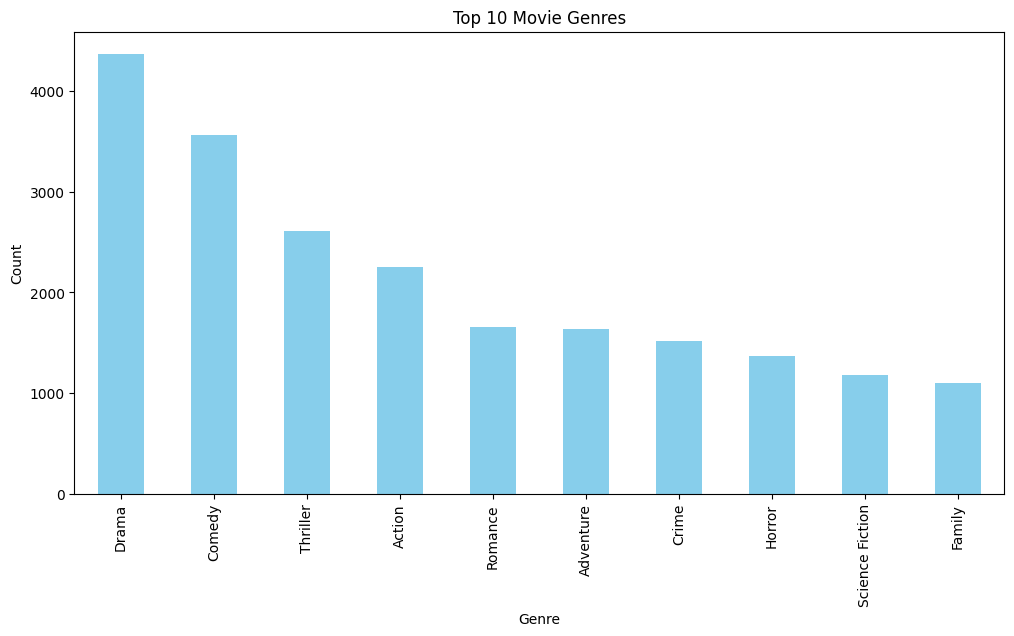

In [18]:
import matplotlib.pyplot as plt


all_genres = [genre for sublist in df_clean['genres'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

After removing stop words, we can observe that meaningful content words like "life", "young", "world", "family", "love" have emerged as the most frequent terms. This is an improvement over our case with stopwords

However, these common content words still appear frequently across multiple genres and don't necessarily help distinguish between them.

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english')) | set(stop_words_spacy)
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_clean['cleaned_overview'] = df_clean['overview'].apply(clean_text)
most_frequent_words(df_clean["cleaned_overview"], 40)

[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump

# criar vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english'
)

# aplicar TF-IDF aos textos pré-processados
X = tfidf.fit_transform(df_clean['cleaned_overview'])

dump(tfidf, 'models/tfidf_vectorizer.pkl')


['models/tfidf_vectorizer.pkl']